[INFO] Loaded theta data: 7432 documents.
[INFO] Loaded 20 topic names.
[INFO] Selected Topic IDs: [11, 17, 3, 12, 6, 20]


/Users/oushilin/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/oushilin/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/oushilin/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Users/oushilin/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a le

[SUCCESS] Plot saved as 'Final_Report_Named_Visualization.png'


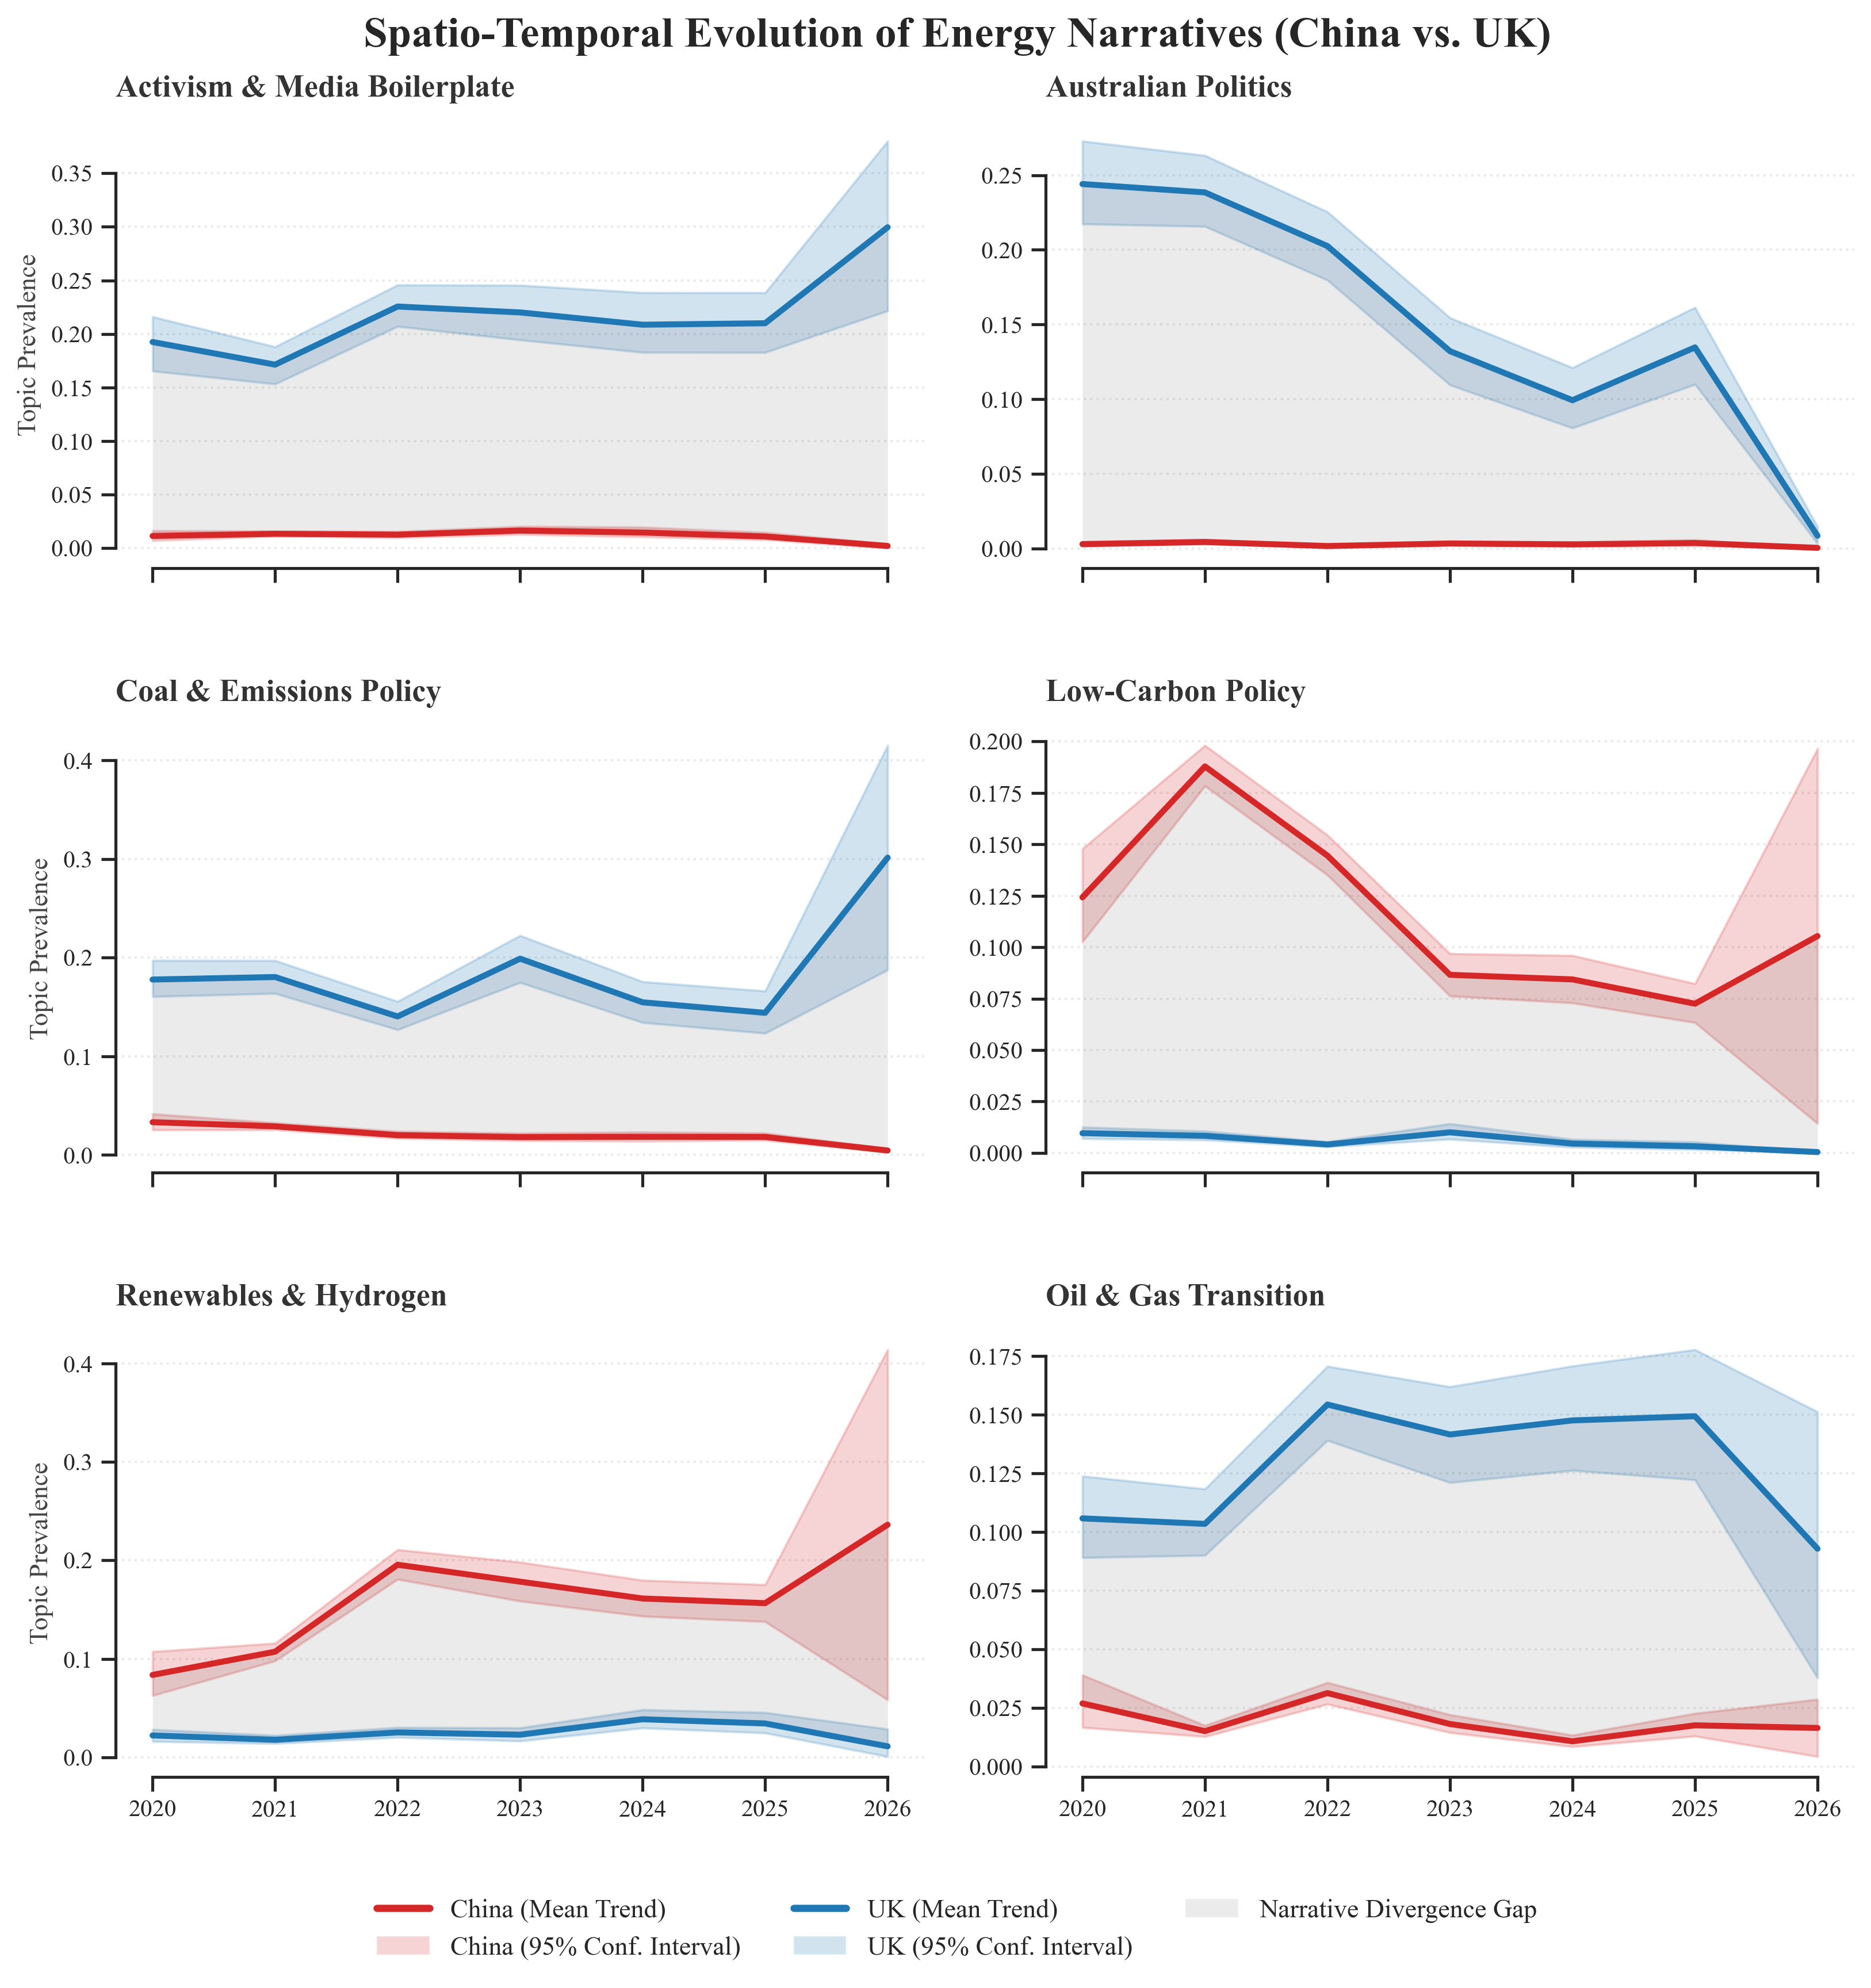

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.lines import Line2D
from matplotlib.patches import Patch

# ==========================================
# 1. Configuration: Academic Style
# ==========================================
# Set plot style to academic standards (clean, serif fonts)
sns.set_theme(style="ticks") 
plt.rcParams.update({
    "font.family": "serif",
    "font.serif": ["Times New Roman"],
    "axes.titlesize": 14,
    "axes.labelsize": 12,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10,
    "legend.fontsize": 11,
    "figure.dpi": 300,
    "lines.linewidth": 2.5
})

# Define colors: China (Red), UK (Blue)
COLOR_CN = "#D62728"
COLOR_UK = "#1F77B4"
PALETTE = {"China": COLOR_CN, "UK": COLOR_UK}

# ==========================================
# 2. Data Loading & Preprocessing
# ==========================================
def load_and_merge_data(theta_file, names_file):
    """
    Loads the theta data and merges it with the topic names from the CSV.
    """
    # A. Load Theta Data
    try:
        df = pd.read_csv(theta_file)
        print(f"[INFO] Loaded theta data: {len(df)} documents.")
    except FileNotFoundError:
        print(f"[ERROR] '{theta_file}' not found.")
        return None, None

    # Ensure 'year' is numeric
    df['year'] = pd.to_numeric(df['year'], errors='coerce')
    
    # B. Load Topic Names
    try:
        names_df = pd.read_csv(names_file)
        # Create a dictionary: {1: "Topic Name", 2: "Another Name"}
        topic_map = dict(zip(names_df['Topic_ID'], names_df['Topic_Name']))
        print(f"[INFO] Loaded {len(topic_map)} topic names.")
    except FileNotFoundError:
        print(f"[ERROR] '{names_file}' not found.")
        return None, None

    # C. Melt to Long Format
    topic_cols = [c for c in df.columns if c.startswith("topic_")]
    df_long = df.melt(
        id_vars=["year", "media"], 
        value_vars=topic_cols, 
        var_name="Topic_Col", 
        value_name="Proportion"
    )
    
    # Extract ID (e.g., 'topic_1' -> 1) and Map Names
    df_long['Topic_ID'] = df_long['Topic_Col'].str.extract('(\d+)').astype(int)
    df_long['Topic_Name'] = df_long['Topic_ID'].map(topic_map)
    
    # Fill missing names if any
    df_long['Topic_Name'] = df_long['Topic_Name'].fillna(df_long['Topic_Col'])
    
    return df_long, topic_map

# ==========================================
# 3. Topic Selection (Finding Divergence)
# ==========================================
def get_top_divergent_topics(df_long, n=6):
    """
    Identifies topics with the largest average difference between China and UK.
    """
    # Group by Topic_ID and Media to get means
    means = df_long.groupby(['Topic_ID', 'media'])['Proportion'].mean().unstack()
    
    if 'China' in means.columns and 'UK' in means.columns:
        means['diff'] = abs(means['China'] - means['UK'])
        top_ids = means.nlargest(n, 'diff').index.tolist()
        return top_ids
    else:
        return df_long['Topic_ID'].unique()[:n]

# ==========================================
# 4. Visualization (The "Beautiful" Plot)
# ==========================================
def plot_academic_multiples(df_long, selected_topic_ids, topic_map):
    """
    Plots a 3x2 grid with explicit confidence intervals and divergence gaps.
    """
    # Create Figure
    fig, axes = plt.subplots(3, 2, figsize=(13, 12), sharex=True)
    axes = axes.flatten()
    
    for i, t_id in enumerate(selected_topic_ids):
        ax = axes[i]
        # Filter data for this topic
        subset = df_long[df_long['Topic_ID'] == t_id]
        topic_name = topic_map.get(t_id, f"Topic {t_id}")
        
        # --- A. Plot Trend Lines + Confidence Intervals ---
        # errorbar=('ci', 95) creates the translucent bands (95% Confidence Interval)
        sns.lineplot(
            data=subset, 
            x="year", 
            y="Proportion", 
            hue="media", 
            palette=PALETTE, 
            ax=ax, 
            legend=False,
            linewidth=2.5,
            errorbar=('ci', 95), 
            n_boot=1000  # Bootstrap for smooth CI
        )
        
        # --- B. Highlight Divergence (Gap) ---
        # Calculate annual means for filling
        agg = subset.groupby(['year', 'media'])['Proportion'].mean().unstack()
        if 'China' in agg.columns and 'UK' in agg.columns:
            ax.fill_between(
                agg.index, agg['China'], agg['UK'], 
                color='#444444', alpha=0.10, linewidth=0
            )

        # --- C. Styling ---
        # Title: Use the name from CSV
        ax.set_title(topic_name, loc='left', fontsize=13, fontweight='bold', color="#333333", pad=10)
        
        # Axis Labels
        ax.set_xlabel("") # Remove x-label for cleaner look
        if i % 2 == 0:
            ax.set_ylabel("Topic Prevalence", fontsize=11, color="#444444")
        else:
            ax.set_ylabel("") # Hide right-column labels
        
        # Ticks & Grid
        ax.tick_params(axis='x', rotation=0)
        sns.despine(ax=ax, trim=True) # Remove top/right spines (Tufte style)
        ax.grid(axis='y', linestyle=':', alpha=0.4) # Subtle horizontal grid

    # ==========================================
    # 5. The "Professional" Legend
    # ==========================================
    # Explain what the shaded regions mean
    legend_elements = [
        # China
        Line2D([0], [0], color=COLOR_CN, lw=3, label='China (Mean Trend)'),
        Patch(facecolor=COLOR_CN, alpha=0.2, label='China (95% Conf. Interval)'),
        
        # UK
        Line2D([0], [0], color=COLOR_UK, lw=3, label='UK (Mean Trend)'),
        Patch(facecolor=COLOR_UK, alpha=0.2, label='UK (95% Conf. Interval)'),
        
        # Divergence Gap
        Patch(facecolor='#444444', alpha=0.10, label='Narrative Divergence Gap')
    ]
    
    # Layout Adjustment
    plt.subplots_adjust(top=0.92, bottom=0.12, hspace=0.35, wspace=0.15)
    
    # Main Title
    fig.suptitle("Spatio-Temporal Evolution of Energy Narratives (China vs. UK)", 
                 fontsize=18, fontweight='bold', y=0.97)

    # Place Legend at Bottom
    fig.legend(
        handles=legend_elements,
        loc='lower center', 
        bbox_to_anchor=(0.5, 0.02),
        ncol=3, 
        frameon=False,
        fontsize=11
    )
    
    # Save Output
    out_file = "Final_Report_Named_Visualization.png"
    plt.savefig(out_file, dpi=300, bbox_inches='tight')
    print(f"[SUCCESS] Plot saved as '{out_file}'")
    plt.show()

# ==========================================
# 6. Main Execution
# ==========================================

# Define file paths
THETA_FILE = "K20_theta.csv"
NAMES_FILE = "K20_topics_with_names.csv"  # Your uploaded file

# Run pipeline
df_processed, topic_mapping = load_and_merge_data(THETA_FILE, NAMES_FILE)

if df_processed is not None:
    # 1. Automatically find the top 6 divergent topics
    top_ids = get_top_divergent_topics(df_processed, n=6)
    print(f"[INFO] Selected Topic IDs: {top_ids}")
    
    # 2. Plot using the names from the CSV
    plot_academic_multiples(df_processed, top_ids, topic_mapping)

[INFO] Loading data...
[SUCCESS] Heatmap saved as 'Final_KeyWords_Heatmap.png'


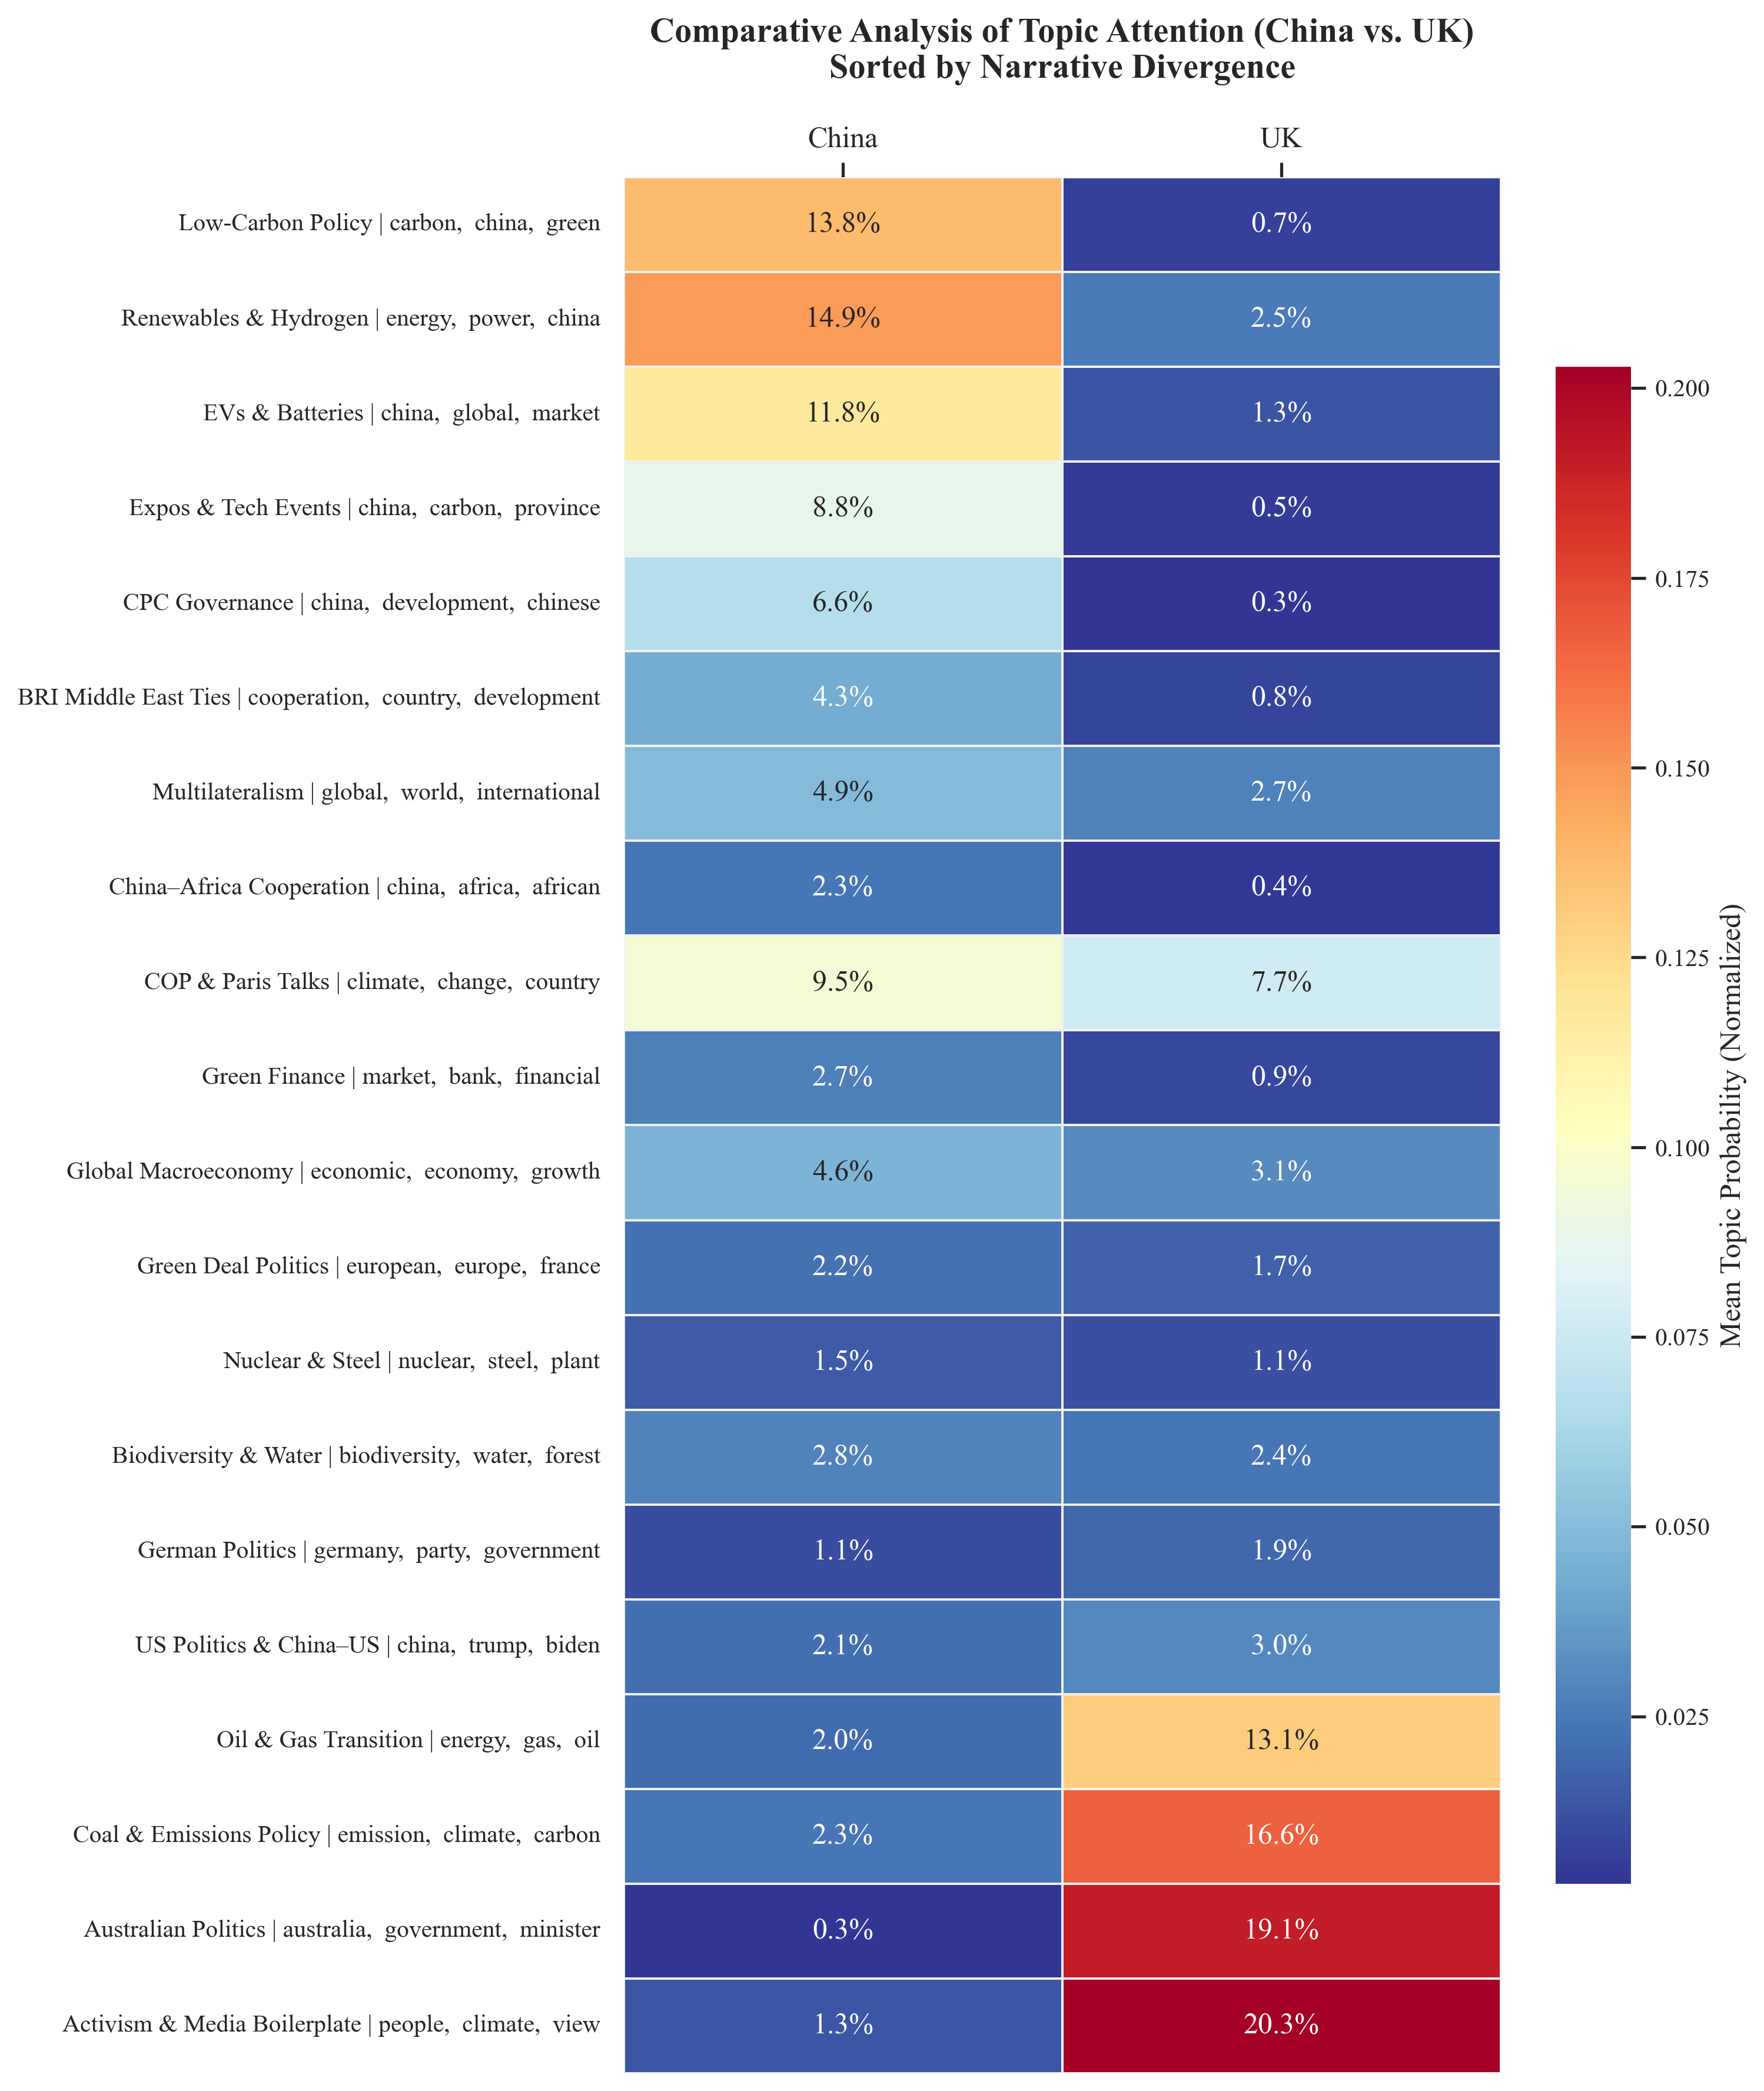

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# ==========================================
# 1. Configuration & Style Setup
# ==========================================
sns.set_theme(style="white")
plt.rcParams.update({
    "font.family": "serif",
    "font.serif": ["Times New Roman"],
    "figure.dpi": 300,
    "axes.labelsize": 12,
    "xtick.labelsize": 12,
    "ytick.labelsize": 10
})

# ==========================================
# 2. Data Loading & Processing
# ==========================================
def load_and_prep_heatmap_data(theta_file, names_file):
    """
    Loads theta data and topic names, calculates MEAN proportions per media,
    and merges them for plotting.
    """
    print("[INFO] Loading data...")
    
    # --- A. Load Theta Data ---
    try:
        df = pd.read_csv(theta_file)
    except FileNotFoundError:
        print(f"[ERROR] File '{theta_file}' not found.")
        return None

    # --- B. Handle Data Imbalance (CRITICAL STEP) ---
    topic_cols = [c for c in df.columns if c.startswith("topic_")]
    
    # Group by 'media' and take the MEAN
    # Result: A DataFrame with 2 rows (China, UK) and N columns (Topics)
    grouped = df.groupby('media')[topic_cols].mean().T # Transpose: Rows=Topics, Cols=Media
    
    # --- C. Load Names & Keywords ---
    try:
        names_df = pd.read_csv(names_file)
    except FileNotFoundError:
        print(f"[ERROR] File '{names_file}' not found.")
        return None
    
    # Extract Top 3 Keywords from 'Highest_Prob' column
    names_df['Short_Keywords'] = names_df['Highest_Prob'].apply(
        lambda x: ", ".join(str(x).split(',')[:3]).strip()
    )
    
    # Create the display label: "Topic Name | word1, word2, word3"
    names_df['Display_Label'] = (
        names_df['Topic_Name'] + " | " + names_df['Short_Keywords']
    )
    
    # Create a mapping dictionary: {1: "Label...", 2: "Label..."}
    id_map = dict(zip(names_df['Topic_ID'], names_df['Display_Label']))
    
    # --- D. Merge & Format ---
    # Convert index "topic_1" -> 1 (int)
    # Note: Extract returns a DataFrame, selecting [0] gives the Series
    grouped.index = grouped.index.str.extract('(\d+)')[0].astype(int)
    
    # Map the names
    grouped['Label'] = grouped.index.map(id_map)
    
    # [FIXED HERE] Create a fallback Series for fillna
    # fillna requires a scalar, dict, or Series. We create a Series indexed by Topic ID.
    fallback_series = pd.Series(
        "Topic " + grouped.index.astype(str), 
        index=grouped.index
    )
    grouped['Label'] = grouped['Label'].fillna(fallback_series)
    
    # Set Label as Index for the heatmap
    grouped = grouped.set_index('Label')
    
    # --- E. Sorting Logic (Contrast Sorting) ---
    if 'China' in grouped.columns and 'UK' in grouped.columns:
        grouped['diff'] = grouped['China'] - grouped['UK']
        grouped = grouped.sort_values('diff', ascending=False)
        # Drop the 'diff' column so it doesn't plot
        plot_data = grouped[['China', 'UK']]
    else:
        plot_data = grouped
        
    return plot_data

# ==========================================
# 3. Heatmap Visualization Logic
# ==========================================
def plot_comparative_heatmap(data):
    """
    Plots a vertical heatmap comparing China vs. UK topic intensity.
    """
    if data is None or data.empty:
        print("[ERROR] No data to plot.")
        return

    # Dynamic height based on number of topics
    h = len(data) * 0.5 + 2
    fig, ax = plt.subplots(figsize=(10, h))
    
    # Draw Heatmap
    sns.heatmap(
        data, 
        cmap="RdYlBu_r", 
        annot=True,      # Show numbers in cells
        fmt=".1%",       # Format as percentage (e.g., 12.5%)
        linewidths=0.5, 
        linecolor='#f0f0f0',
        cbar_kws={'label': 'Mean Topic Probability (Normalized)', 'shrink': 0.8},
        ax=ax
    )
    
    # Aesthetics
    ax.set_title("Comparative Analysis of Topic Attention (China vs. UK)\nSorted by Narrative Divergence", 
                 fontsize=14, fontweight='bold', pad=20)
    ax.set_ylabel("")
    ax.set_xlabel("")
    
    # Move X-axis labels (China/UK) to the top for easier reading
    ax.xaxis.tick_top()
    ax.xaxis.set_label_position('top')
    
    # Save High-Res Image
    output_file = "Final_KeyWords_Heatmap.png"
    plt.tight_layout()
    plt.savefig(output_file, dpi=300, bbox_inches='tight')
    print(f"[SUCCESS] Heatmap saved as '{output_file}'")
    plt.show()

# ==========================================
# 4. Main Execution
# ==========================================

# File paths (Ensure these match your actual files)
THETA_FILE = "K20_theta.csv"
NAMES_FILE = "K20_topics_with_names.csv"

# Run Pipeline
heatmap_data = load_and_prep_heatmap_data(THETA_FILE, NAMES_FILE)
if heatmap_data is not None:
    plot_comparative_heatmap(heatmap_data)